<!-- Badges: -->

<!-- Title: -->
<div align="center">
  <h1><b> Trotterization </b></h1>
  <h2> Quantum Circuit Theory and Implementations </h2>
</div>
<br>

<b>Author:</b> <a target="_blank" href="https://github.com/camponogaraviera">Lucas Camponogara Viera</a>

<div align='center'>
<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/QuCAI-Lab/quantum-circuit-theory"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>
</div>

# Table of Contents

- The Trotter-Susuki formula
- The Heisenberg XXX Spin-1/2 Lattice Model for $N=3$ Three Particles
- Decomposition of $U_{\text{Heis3}}(t)$ using Trotterization
- About the Trotterized Evolution
    - Verifying identities with NumPy
    - Verifying identities with Qiskit Opflow

# &nbsp; <img valign="middle" height="45px" src="https://img.icons8.com/python" width="45" hspace="0px" vspace="0px"> Importing modules

In [1]:
import IPython

import numpy as np 
from scipy.linalg import expm # Numerical exponentiation.

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

from qiskit.opflow import I, X, Y, Z, S, H, CX

In [3]:
### If using Google Colab, one needs to restart Colab Runtime after pip install. ###

try:
  import pkg_resources, watermark
  pkg_resources.require("watermark>=2.3.1") # Force watermark version.
  print(watermark.__version__)
except:
  import subprocess, sys
  if "google.colab" in sys.modules:
    cmd = "python3 -m pip install --upgrade watermark" # Upgrade watermak.

    process = subprocess.Popen(cmd,shell=True,bufsize=1,stdout=subprocess.PIPE, \
                              stderr=subprocess.STDOUT,encoding='utf-8',errors='replace') 
    while True: 
      out = process.stdout.readline() # The first line of the file.
      if out == '' and process.poll() is not None: # Run the loop until condition is True.
        break 
      if out:
        print(out.strip(), flush=False) # Removes leading and trailing empty spaces. 
        sys.stdout.flush()
    #raise # To raise the import error. Upgrade will be successful regardless.

2.3.1


In [4]:
# If you get hit by the error "No module named watermark", run this cell twice!

#%load_ext watermark
%reload_ext watermark
%watermark -a 'LucasCamponogaraViera' -gu 'QuCAI-Lab' -ws 'https://github.com/QuCAI-Lab/quantum-circuit-theory' -w -u -d -v -m -iv

Author: LucasCamponogaraViera

Github username: QuCAI-Lab

Website: https://github.com/QuCAI-Lab/quantum-circuit-theory

Last updated: 2024-02-13

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.21.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.5.0-17-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

IPython  : 8.21.0
watermark: 2.3.1
qiskit   : 0.42.1
numpy    : 1.23.5

Watermark: 2.3.1



In [5]:
print(IPython.sys_info())

{'commit_hash': '8b1204b6c',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/home/lucas/anaconda3/envs/qct/lib/python3.11/site-packages/IPython',
 'ipython_version': '8.21.0',
 'os_name': 'posix',
 'platform': 'Linux-6.5.0-17-generic-x86_64-with-glibc2.35',
 'sys_executable': '/home/lucas/anaconda3/envs/qct/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.11.2 (main, Mar 27 2023, 23:42:44) [GCC 11.2.0]'}


# The Trotter-Susuki formula

Consider the following decomposition for a general Hamiltonian $\hat{H}$:

\begin{align}
\hat{H} = \hat{H}_a + \hat{H}_b.
\end{align}

If the reduced Hamiltonians commute, i.e, $[\hat{H}_{a},\hat{H}_{b}]=\mathbb{O}$, then the evolution operator is a product of reduced evolution operators:

\begin{align}
\hat{U} = e^{-i\hat{H}t/ħ} = e^{-i\hat{H}_{a}t/\hbar-i\hat{H}_{b}t/\hbar} = e^{-i\hat{H}_{a}t/\hbar}e^{-i\hat{H}_{b}t/\hbar} = \hat{U}_{a}\hat{U}_{b} = \hat{U}_{b}\hat{U}_{a}.
\end{align}






In the case where $[H_a^{(0,1)},H_b^{(1,2)}]\ne\mathbb{O}$, one cannot simply write the evolution operator $\hat{U}$ as a product of evolution operators, therefore, another method must be adopted. There are several techniques to approximate a time Unitary evolution $\hat{U}=e^{-i\hat{H}t/\hbar}$ into gate operations for quantum simulation, to name a few:

1. Trotter-Susuki formula.
2. Randomized evolution (Qdrift, density matrix exponentiation).
3. Linear combination of unitaries.
4. Quantum Walks (Qubitization).



The Lie product formula (a.k.a Trotter-Susuki formula) is defined as (setting $\hbar\equiv1$):

\begin{align}
U_{Trotter}(t) = e^{-it\Big(\hat{H}_a + \hat{H}_b\Big)} \equiv \lim_{N\rightarrow\infty}\Big(e^{-it \hat{H}_a/N}e^{-it \hat{H}_b /N}\Big)^{N}.
\end{align}

Advantages of using Trotterization:

- The algorithm is ancilla-free.

- It leverages the commutative property of the component Hamiltonians to achieve efficient simulation.

- It preserves the locality property of some unidimensional systems with nearest neighbor interactions enabling quantum simulation speed up.







The outline of the Trotterization algorithm a.k.a as product-formula method or splitting method is as follows:

**1.** Write the Hamiltonian operator $\hat{H}$ of the system of interest in the form:

\begin{eqnarray}
\hat{H}= \sum_{\gamma=1}^{\Gamma} \hat{H}_{\gamma},
\end{eqnarray}
where $\hat{H}_{\gamma}$ is itself a Hermitian operator.

**2.** Write the unitary evolution operator $U$ in terms of product of exponentials using the first-order Lie-Trotter formula defined as:

\begin{eqnarray}
\mathcal{L}_1(t) = e^{-it \hat{H}_{1}} \cdots e^{-it \hat{H}_{\Gamma}} = e^{-it \hat{H}} + O(t^2),
\end{eqnarray}
where $O(t^2)$ is the trotter error.

**3.** Perform $e^{-it\hat{H}}$ up to some error $\epsilon$ according to the spectral norm:

\begin{eqnarray}
||\hat{U}-e^{-it\hat{H}}|| \leq \epsilon.
\end{eqnarray}

**4.** Define the total cost of the simulation as:
\begin{eqnarray}
\text{total cost} = \text{no. of steps } \times \text{ cost}/\text{step}.
\end{eqnarray}

In step 3, each exponential in the evolution operator $U_{\text{Heis3}}(t)$ is transpiled into a quantum gate.

# The Heisenberg XXX Spin-1/2 Lattice Model for $N=3$ Three Particles

The [Quantum Heisenberg XXX spin-1/2 model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model) is a particular case of the general [XYZ Quantum Heisenberg Model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) when the coupling coefficients are $J_x = J_y = J_z \doteq J$. The particle interaction of the aforementioned spin model for a system of $N$ quantum spin-1/2 particles arranged in a 1D (one-dimensional) Markov chain, where each particle is represented by a qubit, is given by the following `Hamiltonian operator`:

\begin{eqnarray}
h_{\text{heis}} &=& \sum_{\langle jk \rangle =0}^{N-1} J \left(\sigma_x^{(j)} \otimes \sigma_x^{(k)} + \sigma_y^{(j)} \otimes \sigma_y^{(k)} + \sigma_z^{(j)} \otimes \sigma_z^{(k)}\right).
\end{eqnarray}
Where: 
- $J$ is a real-valued [coupling](https://en.m.wikipedia.org/wiki/Coupling_constant) constant that determines the interaction strength.
- $\langle jk \rangle$ specifies interaction only between nearest neighbor qubits $j$ and $k$ ($j,k \in \{0,1,2\}$).
- $\otimes$ denotes the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) symbol between two matrices.

<br></br>
In classical mechanics, the Hamiltonian $H$ corresponds to the sum of kinetic and potential energy of a **time-independent holonomic and monogenic system** \[Goldstein, H.]. In quantum mechanics, the Hamiltonian is promoted to a so-called Hermitian operator $\hat{H}$ represented by a self-adjoint complex matrix within the matrix mechanics formalism.

The Pauli operators in this 1D spin lattice satisfy the following Lie algebra for the (anti-)commutation relations:


\begin{eqnarray}
\text{commutator: } \{\sigma_a^{j}, \sigma_b^{k} \} = 2\delta_{jk}\delta_{ab}\sigma_0^{j},\\
\end{eqnarray}
\begin{eqnarray}
\text{anti-commutator: }
[\sigma_a^{j}, \sigma_b^{k}] = 2i\delta_{jk}\epsilon_{abc}\sigma_c^{j}.
\end{eqnarray}

Where

- $[\hat{A},\hat{B}]$ denotes the bilinear skew-symmetric map $[,]: \mathcal{g} x \mathcal{g} \rightarrow \mathcal{g}$ (a.k.a commutator) between operators $\hat{A}$ and $\hat{B}$:

\begin{align}
[\hat{A},\hat{B}]\doteq\hat{A}\hat{B} - \hat{B}\hat{A}.
\end{align}
- $i=\sqrt{-1}$ denotes the imaginary unit.
- $\epsilon_{abc}$ denotes the normalized Levi-Civita symbol ($\epsilon_{xyz}=1$) with $a, b, c \in \{x,y,z\}$:

\begin{align*}
\varepsilon_{abc} \doteq
\begin{cases}
+1 & \text{for even permutation of }(a,b,c). \\
-1 & \text{for odd permutation of } (a,b,c).  \\
\;\;\,0 & \text{for any repeated index}.
\end{cases}
\end{align*}

- $\delta_{jk}$ denotes the Kronecker delta:

\begin{eqnarray}
\delta_{jk} \doteq \begin{cases}
0, & \mbox{if } j \ne k, \\
1, & \mbox{if } j=k. \end{cases}
\end{eqnarray}
- $\{\sigma_x,\sigma_y,\sigma_z\}$ denotes the $SU(2)$ set of [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) (2x2 complex Hermitian and Unitary matrices sharing equal eigenvalues of $\pm 1$).

For the particular case of a system of $N=3$ spin-1/2 particles arranged in a line, and setting $J=1$, one then has:

\begin{eqnarray}
h_{\text{heis}} &=& \sigma_x^{(0)}\otimes\sigma_x^{(1)}\otimes \mathbb{I}^{(2)} + \mathbb{I}^{(0)} \otimes\sigma_x^{(1)}\otimes\sigma_x^{(2)} + \sigma_y^{(0)}\otimes\sigma_y^{(1)}\otimes \mathbb{I}^{(2)} + \mathbb{I}^{(0)} \otimes \sigma_y^{(1)}\otimes\sigma_y^{(2)} + \mathbb{I}^{(0)} \otimes\sigma_z^{(0)}\otimes\sigma_z^{(1)} + \mathbb{I}^{(0)}\otimes\sigma_z^{(1)}\otimes\sigma_z^{(2)}.
\end{eqnarray}

However, the convention adopted by the quantum community is the following shorthand notation (omitting the Kronecker product ($\otimes$) and the 2x2 identity matrix $\mathbb{I}$):

\begin{eqnarray}
h_{\text{heis3}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}.
\end{eqnarray}

# Decomposition of $U_{\text{Heis3}}(t)$ using Trotterization

Consider the following decomposition for the Hamiltonian $H_{heis3}$:

\begin{align}
H_{heis3} = H_a^{(0,1)} + H_b^{(1,2)},
\end{align}
where
\begin{align}
H_a^{(0,1)}  =\big(X^{(0)} \otimes X^{(1)} + Y^{(0)}\otimes Y^{(1)} + Z^{(0)}\otimes Z^{(1)}\big)\otimes \mathbb{I}^{(2)}, \\
H_b^{(1,2)} = \mathbb{I}^{(0)}\otimes \big(X^{(1)}\otimes X^{(2)} +  Y^{(1)}\otimes Y^{(2)} + Z^{(1)}\otimes Z^{(2)}\big),
\end{align}

We note that the pair of operators in the exponential of $U_{Trotter}(t)$ commute, i.e,

$$[X\otimes X,Y\otimes Y] = [X\otimes X,Z\otimes Z] = [Y\otimes Y,Z\otimes Z] =\mathbb{O}.$$

**Proof:**

Let $\{\sigma_i\}_{i=1}^3$ be the set of Pauli matrices. Considering only the case where $j \ne k$:

\begin{eqnarray}
[\sigma_j \otimes \sigma_j, \sigma_k \otimes \sigma_k] = (\sigma_j \otimes \sigma_j) \cdot (\sigma_k \otimes \sigma_k) - (\sigma_k \otimes \sigma_k) \cdot (\sigma_j \otimes \sigma_j),
\end{eqnarray}

and using $(A\otimes B)\cdot(C\otimes D)=AC\otimes BD$, one then has

\begin{eqnarray}
[\sigma_j \otimes \sigma_j, \sigma_k \otimes \sigma_k]=\sigma_j \sigma_k \otimes \sigma_j \sigma_k - \sigma_k \sigma_j \otimes \sigma_k \sigma_j.
\end{eqnarray}

In the next step, one uses the $\mathfrak{su}(2)$ Lie algebra ($\sigma_j \sigma_k = \delta_{jk} \sigma_0 +i\epsilon_{jkl} \sigma_l$) noting that, for $j \ne k$, it becomes $\sigma_j \sigma_k = i\epsilon_{jkl} \sigma_l$. 

Hence

\begin{eqnarray} 
[\sigma_j \otimes \sigma_j, \sigma_k \otimes \sigma_k] &=& (i\epsilon_{jkl} \sigma_l \otimes i\epsilon_{jkl} \sigma_l) - (i\epsilon_{kjl} \sigma_l \otimes i\epsilon_{kjl} \sigma_l) \\
&=& (i^2 \epsilon^2_{jkl} \sigma_l \otimes \sigma_l) -(i^2 \epsilon^2_{kjl}\sigma_l \otimes \sigma_l),
\end{eqnarray}

which after using the anticyclic (odd) permutation property of the Levi-Civita epsilon $\epsilon_{ijk} = -\epsilon_{jik}$, becomes

\begin{eqnarray} 
&=& (i^2 \epsilon_{jkl}^2 \sigma_l \otimes \sigma_l) -(i^2 (-\epsilon_{jkl})^2 \sigma_l \otimes \sigma_l) \\
&=& (i^2 \epsilon^2_{jkl} \sigma_l \otimes \sigma_l)-(i^2 \epsilon^2_{jkl}\sigma_l \otimes \sigma_l)\\
&=& \mathbb{O}.
\end{eqnarray}

Q.E.D.

With the above result in hands, the exponential $e^{-itH_a^{01}} $ can be written in the form:

\begin{eqnarray}
e^{-itH_a^{01}} &=& e^{-it(X\otimes X+ Y\otimes Y + Z\otimes Z)\otimes \mathbb{I}} \\ 
&=& e^{-it(X\otimes X\otimes \mathbb{I} + Y\otimes Y\otimes \mathbb{I} + Z\otimes Z\otimes \mathbb{I})} \\
&=& e^{-itX\otimes X\otimes \mathbb{I}}e^{-itY\otimes Y\otimes \mathbb{I}}e^{-itZ\otimes Z\otimes \mathbb{I}},
\end{eqnarray}

which after using $e^{A\otimes \mathbb{I}} = e^{A}\otimes \mathbb{I}$ becomes

\begin{eqnarray}
e^{-itH_a^{01}}&=& \Big(e^{-itX\otimes X}\otimes \mathbb{I}\Big)\Big(e^{-itY\otimes Y}\otimes \mathbb{I}\Big)\Big(e^{-itZ\otimes Z}\otimes \mathbb{I}\Big), \\
&=& \Big(e^{-itX\otimes X}\Big)\Big(e^{-itY\otimes Y}\Big)\Big(e^{-itZ\otimes Z}\Big)\otimes \mathbb{I},
\end{eqnarray}

where it was used $(A \otimes \mathbb{I})(B \otimes \mathbb{I})(C \otimes \mathbb{I})=(AB\otimes \mathbb{I})(C \otimes \mathbb{I})=(ABC)\otimes \mathbb{I}$.

And equivalenty for $e^{-itH_b^{12}}$:

\begin{eqnarray}
e^{-itH_b^{12}} &= \mathbb{I}\otimes\Big( e^{-itX\otimes X}\Big)\Big( e^{-itY\otimes Y}\Big)\Big( e^{-itZ\otimes Z}\Big).
\end{eqnarray}

The unitary evolution operator for the decomposition of $H_{heis3}$ according to the Trotter-Suzuki fomula thus becomes:

\begin{eqnarray}
U_{\text{Heis3}}(t) &=& e^{-itH_{heis3}} = e^{-it\Big(H_a^{(0,1)} + H_b^{(1,2)}\Big)} = \lim_{N\rightarrow\infty}\Big(e^{-it H_a^{(0,1)}/N}e^{-it H_b^{(1,2)} /N}\Big)^{N}\\
&=& \lim_{N\rightarrow\infty}\left(\Big(e^{-it X^0\otimes X^1/N}e^{-it Y^0\otimes Y^1/N}e^{-it Z^0\otimes Z^1/N}\otimes \mathbb{I}\Big)\Big(\mathbb{I}\otimes e^{-it X^1\otimes X^2/N}e^{-it Y^1\otimes Y^2/N}e^{-it Z^1 \otimes Z^2/N}\Big)\right)^{N}.
\end{eqnarray}

With the definitions

\begin{eqnarray}
XX(2t)^{(j,k)}\equiv e^{-it X^j \otimes X^k}, \\
YY(2t)^{(j,k)}\equiv e^{-it Y^j \otimes Y^k}, \\
ZZ(2t)^{(j,k)}\equiv e^{-it Z^j \otimes Z^k},
\end{eqnarray}

one then has:

\begin{eqnarray}
U_{\text{Heis3}}(t) = \lim_{N\rightarrow\infty}\Big[\Big(XX(2t/N)^{(0,1)}YY(2t/N)^{(0,1)}ZZ(2t/N)^{(0,1)}\otimes \mathbb{I}\Big)\Big(\mathbb{I}\otimes XX(2t/N)^{(1,2)}YY(2t/N)^{(1,2)}ZZ(2t/N)^{(1,2)}\Big)\Big]^{N}.
\end{eqnarray}

# About the Trotterized Evolution

Is it possible to change the order of the gates in the trotterized circuit?

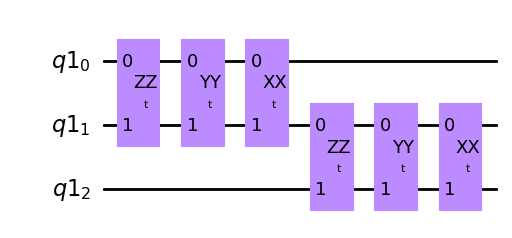

In [6]:
t = Parameter('t')
qr = QuantumRegister(2)

ZZ_qc = QuantumCircuit(qr, name='ZZ')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
ZZg = ZZ_qc.to_instruction()

XX_qc = QuantumCircuit(qr, name='XX')
XX_qc.h([0,1])
XX_qc.append(ZZg, [0,1])
XX_qc.h([0,1])
XXg = XX_qc.to_instruction()

YY_qc = QuantumCircuit(qr, name='YY')
YY_qc.sdg([0,1])
YY_qc.h([0,1])
YY_qc.append(ZZg, [0,1])
YY_qc.h([0,1])
YY_qc.s([0,1])
YYg = YY_qc.to_instruction()

num_qubits = 3
Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZg, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YYg, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XXg, [Trot_qr[i], Trot_qr[i+1]])
Trot_gate = Trot_qc.to_instruction()
Trot_qc.draw(output='mpl')

Consider the following decomposition for each trotterized evolution time step:

$$U(t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i t X_iX_{i+1}} e^{-i t Y_iY_{i+1}} e^{-i t Z_iZ_{i+1}} \Big)  \Big(\prod_{i \in \rm{even}} e^{-i t X_iX_{i+1}} e^{-i t Y_iY_{i+1}} e^{-i t Z_iZ_{i+1}}\Big).$$

Explicitly, the unitary operator correspoding to the circuit above reads (little-endian convention):

\begin{eqnarray}
U(t) &=& (e^{-i t (X_2 \otimes X_1)}\otimes \mathbb{I}_0) (e^{-i t (Y_2 \otimes Y_1)}\otimes \mathbb{I}_0)(e^{-i t (Z_2 \otimes Z_1)}\otimes \mathbb{I}_0) (\mathbb{I}_2\otimes e^{-i t (X_1\otimes X_0)}) (\mathbb{I}_2 \otimes e^{-i t (Y_1\otimes Y_0)})(\mathbb{I}_2 \otimes e^{-i t (Z_1\otimes Z_0)})\\ 
&=& e^{-it (X_2 \otimes X_1 \otimes \mathbb{I}_0)} e^{-i t (Y_2 \otimes Y_1 \otimes \mathbb{I}_0)} e^{-i t (Z_2 \otimes Z_1 \otimes \mathbb{I}_0)} e^{-it (\mathbb{I}_2\otimes X_1\otimes X_0)} e^{-i t (\mathbb{I}_2 \otimes Y_1\otimes Y_0)}e^{-i t (\mathbb{I}_2 \otimes Z_1\otimes Z_0)}.
\end{eqnarray}

Where it was used $e^{A\otimes \mathbb{I}} = e^{A}\otimes \mathbb{I}$.

Moreover, (for $j\neq k$):

$$[\sigma_j\otimes\sigma_j,\sigma_k\otimes\sigma_k]=\mathbb{O},$$

meaning that
$$[X \otimes X, Y \otimes Y] = [X \otimes X, Z \otimes Z] = [Y \otimes Y, Z \otimes Z]=\mathbb{O}.$$

Since $e^{A+B}=e^Ae^B$ iff $[A,B] = \mathbb{O}$, one then has
 
$$e^{-i t (X\otimes X+Y\otimes Y)}= e^{-i t X\otimes X} e^{-i t Y\otimes Y} = e^{-i t Y\otimes Y}  e^{-i t X\otimes X},$$

and since $[A \otimes \mathbb{I}, B \otimes \mathbb{I}] = [A, B] \otimes \mathbb{I}= \mathbb{O}$ iff $[A,B] = \mathbb{O}$, then

$$e^{-i  t(X\otimes X\otimes \mathbb{I} + Y\otimes Y\otimes \mathbb{I})}=e^{-i t X\otimes X\otimes \mathbb{I}}e^{-i tY\otimes Y\otimes \mathbb{I}} = e^{-i t Y\otimes Y \otimes \mathbb{I}}  e^{-i t X\otimes X \otimes \mathbb{I}},$$

such that
$$e^{-it(X\otimes X\otimes I + Y\otimes Y\otimes I + Z\otimes Z\otimes I)} = e^{-itX\otimes X\otimes I}e^{-itY\otimes Y\otimes I}e^{-itZ\otimes Z\otimes I}.$$

However, one should also note that (for $j\neq k$):

$$[\sigma_j\otimes\sigma_j\otimes\sigma_0,\sigma_0\otimes\sigma_k\otimes\sigma_k] \ne \mathbb{O},$$

so that
\begin{eqnarray}
e^{-i t (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} &\neq& e^{-i t Y\otimes Y\otimes \mathbb{I}} e^{-i t \mathbb{I}\otimes X\otimes X},
\end{eqnarray}

hence

\begin{eqnarray}
e^{-i t Y\otimes Y \otimes \mathbb{I}}e^{-i t\mathbb{I} \otimes X \otimes X} &\ne& e^{-i t\mathbb{I}\otimes X \otimes X}e^{-i t Y \otimes Y \otimes \mathbb{I}}\\
e^{-itX\otimes X\otimes I}e^{-itI\otimes Z\otimes Z} &\neq& e^{-itI\otimes Z\otimes Z}e^{-itX\otimes X\otimes I}.
\end{eqnarray}

## Proof that $[\sigma_j\otimes\sigma_j\otimes\sigma_0,\sigma_0\otimes\sigma_k\otimes\sigma_k] \ne \mathbb{O}$.

Let $\{\sigma_i\}_{i=1}^3$ be the set of Pauli matrices. Considering only the case where $j \ne k$.

\begin{align}
[\sigma_j \otimes \sigma_j \otimes \sigma_0, \sigma_0 \otimes \sigma_k \otimes \sigma_k] = (\sigma_j \otimes \sigma_j \otimes \sigma_0)(\sigma_0 \otimes \sigma_k \otimes \sigma_k)-(\sigma_0 \otimes \sigma_k \otimes \sigma_k)(\sigma_j \otimes \sigma_j \otimes \sigma_0).
\end{align}

From here, using the associative property $(A \otimes B)\otimes C = A\otimes (B \otimes C)$, one may choose the following subspaces on which the operators will act

\begin{align}
&= (\sigma_j \otimes (\sigma_j \otimes \sigma_0))(\sigma_0 \otimes (\sigma_k \otimes \sigma_k))-(\sigma_0 \otimes (\sigma_k \otimes \sigma_k))(\sigma_j \otimes (\sigma_j \otimes \sigma_0)).
\end{align}

Now, the property $(A \otimes B)(C \otimes D) = AC \otimes BD$ yields

\begin{align}
&= (\sigma_j \sigma_0) \otimes [(\sigma_j \otimes \sigma_0)(\sigma_k \otimes \sigma_k)] - (\sigma_0\sigma_j) \otimes [(\sigma_k \otimes \sigma_k)(\sigma_j \otimes \sigma_0)],
\end{align}

applying the aforementioned property again, for the square brackets, yields

\begin{align}
&= (\sigma_j \sigma_0) \otimes [\sigma_j \sigma_k \otimes \sigma_0 \sigma_k] - (\sigma_0 \sigma_j) \otimes [\sigma_k \sigma_j \otimes \sigma_k \sigma_0] \\
&=\sigma_j \otimes [\sigma_j \sigma_k \otimes \sigma_k] - \sigma_j \otimes [\sigma_k \sigma_j \otimes \sigma_k].
\end{align}

Now, using the $\mathfrak{su}(2)$ Lie algebra ($\sigma_j \sigma_k = \delta_{jk} \sigma_0 +i\epsilon_{jkl} \sigma_l$) and noting that, for $j \ne k$, it becomes $\sigma_j \sigma_k = i\epsilon_{jkl} \sigma_l$, one then gets

\begin{align}
&=(\sigma_j \otimes i\epsilon_{jkl} \sigma_l \otimes \sigma_k)-(\sigma_j \otimes i\epsilon_{kjl} \sigma_l \otimes \sigma_k),
\end{align}

and finally, using $\epsilon_{ijk}=-\epsilon_{jik}$

\begin{align}
&=(\sigma_j \otimes i\epsilon_{jkl} \sigma_l \otimes \sigma_k)+(\sigma_j \otimes i\epsilon_{jkl} \sigma_l \otimes \sigma_k) \\
&= 2(\sigma_j \otimes i\epsilon_{jkl} \sigma_l \otimes \sigma_k) = 2i\epsilon_{jkl}\sigma_j\otimes \sigma_l \otimes \sigma_k \ne 0.
\end{align}

Q.E.D.

## Verifying identities with NumPy

In [7]:
'''Eigenstates of the Pauli-Z gate (Z-basis):'''
zero=np.array([[1,0]]) # A 2-D row-like (bra vector) numpy array representing the classical state <0|.
one=np.array([[0,1]])  # A 2-D row-like (bra vector) numpy array representing the classical state <1|.

'''Eigenstates of the Pauli-X gate (X-basis):'''
plus=1/(np.sqrt(2))*(zero+one)      # 2-D row-like numpy array (bra vector) representing the superposition state <+| = 1/[sqrt(2)](<0| + <1|).
minus=1/(np.sqrt(2))*(zero-one)     # 2-D row-like numpy array (bra vector) representing the superposition state <-| = 1/[sqrt(2)](<0| - <1|).

'''1-qubit gates SU(2):'''
sigma0 = np.identity(2) # Matrix of the identity gate.
sigma1 = np.array([[0,1],[1,0]], dtype=(np.float32)) # Matrix of the Pauli-X gate that performs a Pi radian rotation around the x-axis.
sigma2 = np.array([[0,-1j],[1j,0]], dtype=(np.complex64)) # Matrix of the Pauli-Y gate. Y=iXZ.

'''2-qubit gates SU(4):'''
XX = np.kron(sigma1,sigma1) # Matrix of the XX gate.
YY = np.kron(sigma2,sigma2) # Matrix of the YY gate.

$$e^{-it(X\otimes X + Y\otimes Y )} = e^{-itX\otimes X}e^{-itY\otimes Y}:$$

Obs: setting $t=1$.

In [8]:
(expm(-1j*(XX+YY)).round(6) == (expm(-1j*XX)@expm(-1j*YY)).round(6)).all()

True

$$e^{-itX\otimes X}e^{-itY\otimes Y}=e^{-itY\otimes Y}e^{-itX\otimes X}:$$

Obs: setting $t=1$.

In [9]:
((expm(-1j*XX)@expm(-1j*YY)).round(6) == (expm(-1j*YY)@expm(-1j*XX)).round(6)).all()

True

$$e^{-i\ t (X\otimes X \otimes \mathbb{I} + Y\otimes Y \otimes \mathbb{I})} = e^{-i\ t X\otimes X \otimes \mathbb{I}}e^{-i\ t Y\otimes Y \otimes \mathbb{I}}:$$

Obs: setting $t=1$.

In [10]:
XXI = np.kron(XX, sigma0)
YYI = np.kron(YY, sigma0)

(expm(-1j*(XXI+YYI)).round(6) == (expm(-1j*XXI)@expm(-1j*YYI)).round(6)).all()

True

$$ e^{-i t X\otimes X \otimes \mathbb{I}} e^{-i t Y\otimes Y \otimes \mathbb{I}} = e^{-i t Y\otimes Y \otimes \mathbb{I}}  e^{-i t X\otimes X \otimes \mathbb{I}}:$$

Obs: setting $t=1$.

In [11]:
((expm(-1j*XXI)@expm(-1j*YYI)).round(6) == (expm(-1j*YYI)@expm(-1j*XXI)).round(6)).all()

True

$$e^{-it (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} \ne e^{-it Y\otimes Y\otimes \mathbb{I}} e^{-i t \mathbb{I}\otimes X\otimes X}:$$

Obs: setting $t=1$.

In [12]:
'''Return should be >>> False.'''

IXX = np.kron(sigma0, XX)

(expm(-1j*(YYI+IXX)).round(6) == (expm(-1j*YYI)@expm(-1j*IXX)).round(6)).all()

False

## Verifying identities with Qiskit Opflow

In [13]:
H1 = (X^X^I)+(Y^Y^I)
H2 = (X^X^I)+(I^Y^Y)

$$[X\otimes X \otimes I,I\otimes Z\otimes Z] \neq 0.$$

In [14]:
((X^X^I)@(I^Z^Z))-((I^Z^Z)@(X^X^I))

PauliSumOp(SparsePauliOp(['XYZ', 'XYZ'],
              coeffs=[0.-1.j, 0.-1.j]), coeff=1.0)

$$e^{-it (X\otimes X \otimes \mathbb{I} + Y\otimes Y \otimes \mathbb{I})} = e^{-it X\otimes X \otimes \mathbb{I}}e^{-it Y\otimes Y \otimes \mathbb{I}}:$$

Obs: setting $t=1$.

In [15]:
H1 = (X^X^I)+(Y^Y^I)
(H1.exp_i().to_matrix().round(7) == ((X^X^I).exp_i()@(Y^Y^I).exp_i()).to_matrix().round(7)).all()

True

$$e^{-it (Y\otimes Y \otimes \mathbb{I}+\mathbb{I}\otimes X\otimes X)} \ne e^{-it Y\otimes Y\otimes \mathbb{I}} e^{-it \mathbb{I}\otimes X\otimes X}:$$

Obs: setting $\Delta t=1$.

In [16]:
'''Return should be >>> False.'''

H2 = (Y^Y^I)+(I^X^X)
(H2.exp_i().to_matrix().round(3) == ((Y^Y^I).exp_i()@(I^X^X).exp_i()).to_matrix().round(3)).all()

False

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/book" width="45" hspace="0px" vspace="0px"></a> References<a name="ref" />

\[1] Nielsen MA, Chuang IL. 2010. Quantum Computation and Quantum Information. New York: [Cambridge Univ. Press.](https://doi.org/10.1017/CBO9780511976667) 10th Anniv. Ed.<a name="ref1" />  
- Corollary 4.2, pg. 176: Gate decomposition.
- Theorem 4.3, pg. 207: Trotter formula. 
- Chapter 4.7.2, pg. 206: The quantum simulation algorithm. 

\[2] [ibmq-qsim-challenge.ipynb](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb).

\[3] [ibmq-qsim-sup-mat.ipynb](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-sup-mat.ipynb).

\[4] [YQIS 6 Invited 8: Yuan Su, Trotterization and Trotter error](https://www.youtube.com/watch?v=KPofFJc57gU).<a name="ref5" />  